# Titanic Dataset preprocessing

## Libraries and configuration

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
plt.style.use(['grid', 'science', 'notebook'])

dataset = "data/Titanic-Dataset.csv"

## Load the dataset

#### Dataset description

- PassengerID: Passenger ID
- Survived: 0 = Died, 1 = Survived
- Pclass: Ticket class (1, 2, 3)
- Name: Name of the passenger
- Gender: Gender of the passenger
- Age: Age of the passenger
- SibSp: Number of sibilings/spouses on board
- ParCh: Number of parents/children on board
- Ticket: Ticket number
- Fare: Passenger fare
- Cabin: Cabin number
- Embarked: Port of embarkment (C = Cherbourg, Q = Queenstown, S = Southampton)

In [3]:
data = pd.read_csv(dataset)
data.rename(columns={"PassengerId": "PassengerID", "Sex": "Gender", "Parch": "ParCh"}, inplace=True)
data["Gender"] = data["Gender"].astype("category")
data["Pclass"] = data["Pclass"].astype("category")
data["Survived"] = data["Survived"].astype("category")
data["Embarked"] = data["Embarked"].astype("category")

print(f"Number of data points: {data.shape[0]}")
data.head()

Number of data points: 891


,PassengerID,Survived,Pclass,Name,Gender,Age,SibSp,ParCh,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Clean the dataset

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerID  891 non-null    int64   
 1   Survived     891 non-null    category
 2   Pclass       891 non-null    category
 3   Name         891 non-null    object  
 4   Gender       891 non-null    category
 5   Age          714 non-null    float64 
 6   SibSp        891 non-null    int64   
 7   ParCh        891 non-null    int64   
 8   Ticket       891 non-null    object  
 9   Fare         891 non-null    float64 
 10  Cabin        204 non-null    object  
 11  Embarked     889 non-null    category
dtypes: category(4), float64(2), int64(3), object(3)
memory usage: 59.8+ KB


The column `Cabin` has a lot of missing values (~77%), so it's probably best to drop it altogether. This is unfortunate, as the position of the cabin could have an impact on the chances of surviving the accident.

Also, `PassengerID` is just a unique number identifying the passenger and it has no influence on the outcome, so it is dropped as well.

The information about the `Name` of the passenger and their `Ticket` number is likely to be irrelevant to determine their survival chance, and it would be difficult to handle. The information about the social class (that could possibly be attained from the `Name`) is already present in the `Fare`.

In [5]:
data.drop(['PassengerID', 'Cabin'], axis=1, inplace=True)
data.drop(['Name', 'Ticket'], axis=1, inplace=True)
data.head()

,Survived,Pclass,Gender,Age,SibSp,ParCh,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


## Impute missing values

In [6]:
from sklearn.impute import SimpleImputer

Since there are only two passenger missing the port of embarkment, it is safe to just assign the mode to those passengers.

In [7]:
print(f"Number of missing port: {data["Embarked"].isna().sum()} over {len(data)} passengers (~{data["Embarked"].isna().sum() / len(data) * 100:.2f}%)")

Number of missing port: 2 over 891 passengers (~0.22%)


In [8]:
mode_imp = SimpleImputer(strategy='most_frequent')
data["Embarked"] = mode_imp.fit_transform(data[["Embarked"]]).ravel()
data.head()

,Survived,Pclass,Gender,Age,SibSp,ParCh,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


The number of passengers missing the age is more significant (~20%). A more sophisticated approach is necessary.

In [9]:
print(f"Number of missing ages: {data["Age"].isna().sum()} over {len(data)} passengers (~{data["Age"].isna().sum() / len(data) * 100:.2f}%)")

Number of missing ages: 177 over 891 passengers (~19.87%)


In [10]:
imp = SimpleImputer(strategy='mean')
data["Age"] = imp.fit_transform(data[["Age"]]).ravel()
data.head()

,Survived,Pclass,Gender,Age,SibSp,ParCh,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


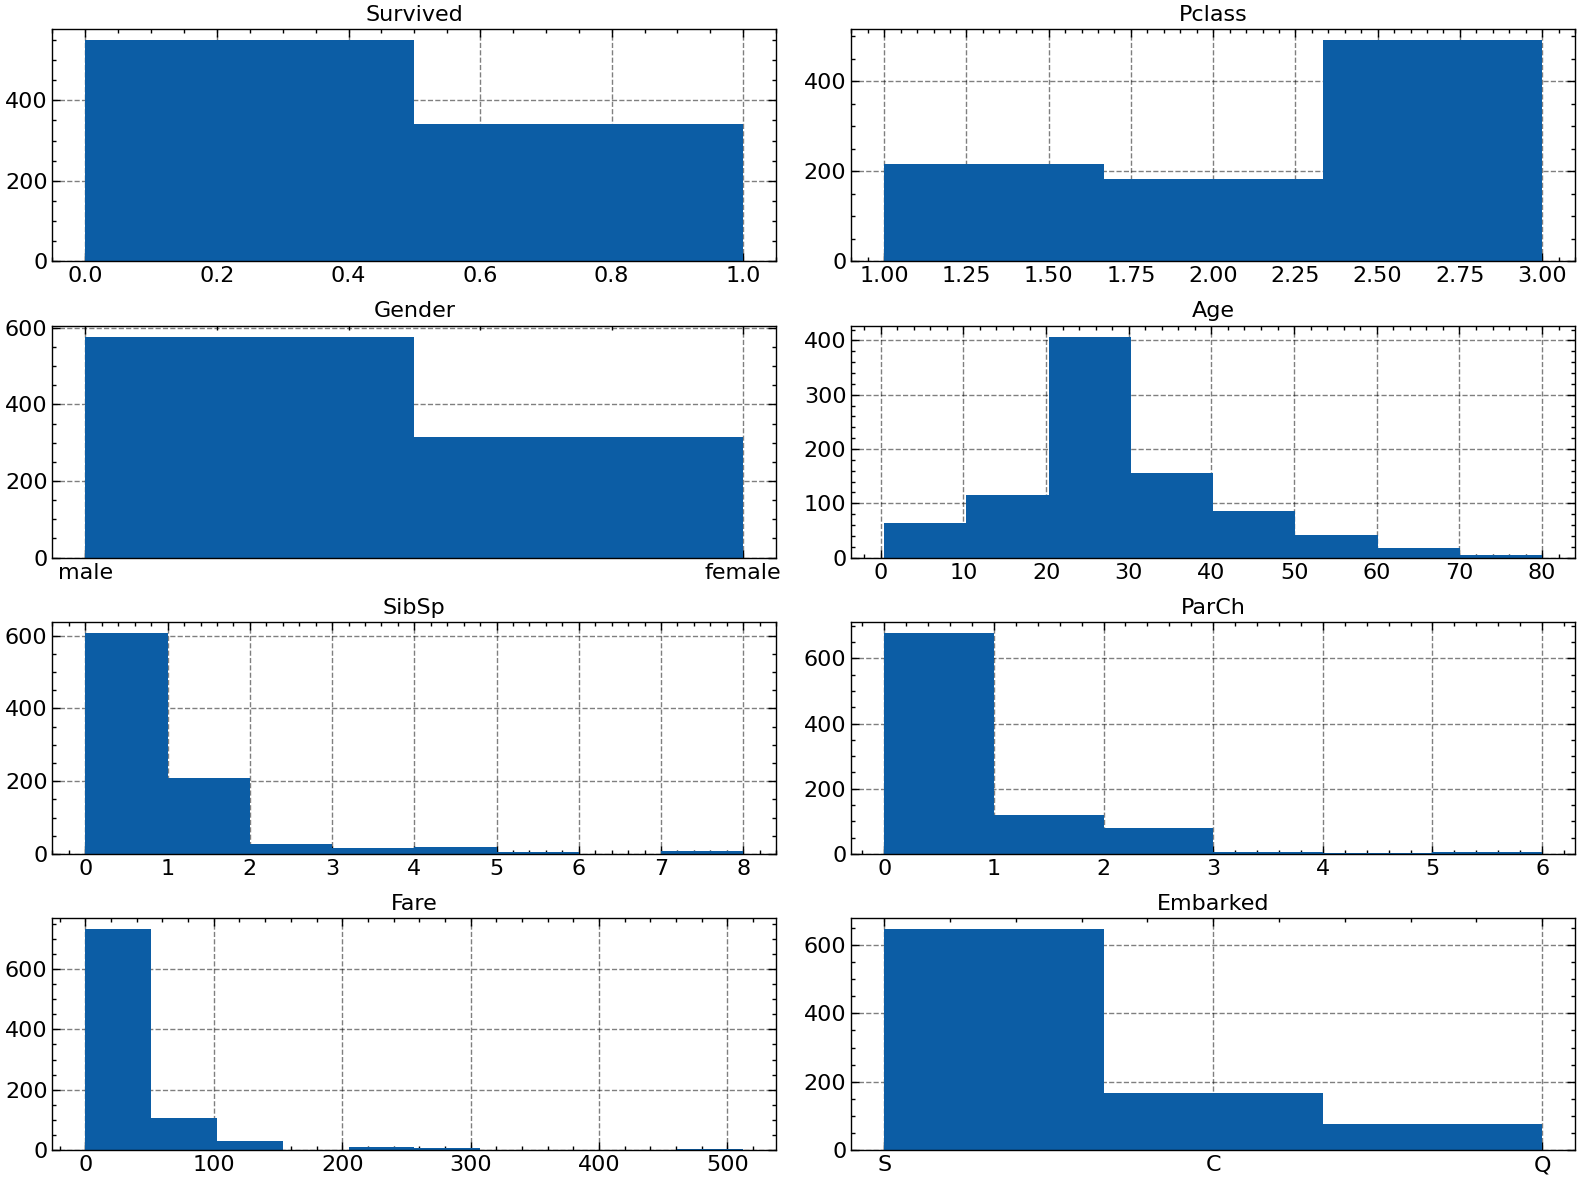

In [11]:
fig, axes = plt.subplots(len(data.columns) // 2, len(data.columns) // 4, figsize=(16, 12))

bins = [2, 3, 2, 8, 'auto', 'auto', 10, 3]

for ax, col, nbins in zip(axes.ravel(), data.columns, bins):
    ax.set_title(col)
    ax.hist(data[col], bins=nbins)

fig.tight_layout()
plt.show()

## Data standardization

In [12]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder

In [13]:
scaler = StandardScaler().fit(data[["Age", "Fare"]])
means = scaler.mean_
stds = scaler.scale_
data[["Age", "Fare"]] = scaler.transform(data[["Age", "Fare"]])
data.head()

,Survived,Pclass,Gender,Age,SibSp,ParCh,Fare,Embarked
0,0,3,male,-0.592481,1,0,-0.502445,S
1,1,1,female,0.638789,1,0,0.786845,C
2,1,3,female,-0.284663,0,0,-0.488854,S
3,1,1,female,0.407926,1,0,0.420730,S
4,0,3,male,0.407926,0,0,-0.486337,S


## Encoding of categorical data

In [14]:
ord_enc = OrdinalEncoder()
onehot_enc = OneHotEncoder()
label_enc = LabelEncoder()

data[["Pclass", "Gender"]] = ord_enc.fit_transform(data[["Pclass", "Gender"]])

transformed = onehot_enc.fit_transform(data[["Embarked"]])
# Create a Pandas DataFrame of the hot encoded column
ohe_df = pd.DataFrame(transformed.toarray(), columns=onehot_enc.get_feature_names_out()).astype(int)
# concat with original data
data = pd.concat([data, ohe_df], axis=1).drop(["Embarked"], axis=1)

data["Survived"] = label_enc.fit_transform(data["Survived"])

In [15]:
data.head()

,Survived,Pclass,Gender,Age,SibSp,ParCh,Fare,Embarked_C,Embarked_Q,Embarked_S
0,0,2.0,1.0,-0.592481,1,0,-0.502445,0,0,1
1,1,0.0,0.0,0.638789,1,0,0.786845,1,0,0
2,1,2.0,0.0,-0.284663,0,0,-0.488854,0,0,1
3,1,0.0,0.0,0.407926,1,0,0.420730,0,0,1
4,0,2.0,1.0,0.407926,0,0,-0.486337,0,0,1


## Save preprocessed dataset

In [16]:
data.to_csv("data/Titanic-Dataset-Preprocessed.csv", index=False)